In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import tqdm

import BB_DL
import MultiBatchLBFGS.functions.LBFGS as LBFGS
import MultiBatchLBFGS.functions.utils as LBFGSutils

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batch_size = 64
overlap_ratio = 0.25  # for LBFGS
max_iter = 20

In [3]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


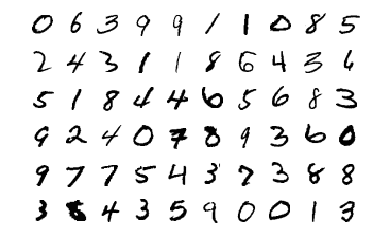

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [5]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1)).cuda()
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [6]:
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1).cuda()

logps = model(images).cpu() #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss


In [9]:
optimizer = BB_DL.BB(model.parameters(), lr=0.003, steps=len(trainloader), 
               beta=4. / len(trainloader), max_lr=1, min_lr=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in tqdm.tqdm(range(epochs)):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad()
        
        output = model(images.cuda())
        loss = criterion(output, labels.cuda())
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

  7%|▋         | 1/15 [00:08<01:57,  8.36s/it]

Epoch 0 - Training loss: 1.8710703120302798


 13%|█▎        | 2/15 [00:17<01:49,  8.45s/it]

Epoch 1 - Training loss: 0.8137801645407036


 20%|██        | 3/15 [00:25<01:40,  8.39s/it]

Epoch 2 - Training loss: 0.4792248476415809


 27%|██▋       | 4/15 [00:33<01:32,  8.39s/it]

Epoch 3 - Training loss: 0.38161106570474884


 33%|███▎      | 5/15 [00:41<01:22,  8.22s/it]

Epoch 4 - Training loss: 0.338197618619656


 40%|████      | 6/15 [00:49<01:12,  8.09s/it]

Epoch 5 - Training loss: 0.31609076879886805


 47%|████▋     | 7/15 [00:57<01:05,  8.13s/it]

Epoch 6 - Training loss: 0.7244832620167656


 53%|█████▎    | 8/15 [01:06<00:58,  8.29s/it]

Epoch 7 - Training loss: 0.2270648201732938


 60%|██████    | 9/15 [01:14<00:49,  8.28s/it]

Epoch 8 - Training loss: 0.17906409039743929


 67%|██████▋   | 10/15 [01:22<00:40,  8.14s/it]

Epoch 9 - Training loss: 0.1531571692117909


 73%|███████▎  | 11/15 [01:30<00:32,  8.10s/it]

Epoch 10 - Training loss: 0.13336133886017462


 80%|████████  | 12/15 [01:38<00:24,  8.06s/it]

Epoch 11 - Training loss: 0.11953250439202132


 87%|████████▋ | 13/15 [01:46<00:16,  8.16s/it]

Epoch 12 - Training loss: 0.1088433122919646


 93%|█████████▎| 14/15 [01:54<00:08,  8.09s/it]

Epoch 13 - Training loss: 0.09838563364360538


100%|██████████| 15/15 [02:02<00:00,  8.09s/it]

Epoch 14 - Training loss: 0.09084786845446587

Training Time (in minutes) = 2.043663799762726


In [15]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

Predicted Digit = 3


NameError: name 'view_classify' is not defined

In [12]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img.cuda())

    
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
        correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 157

Model Accuracy = 0.9808917197452229
